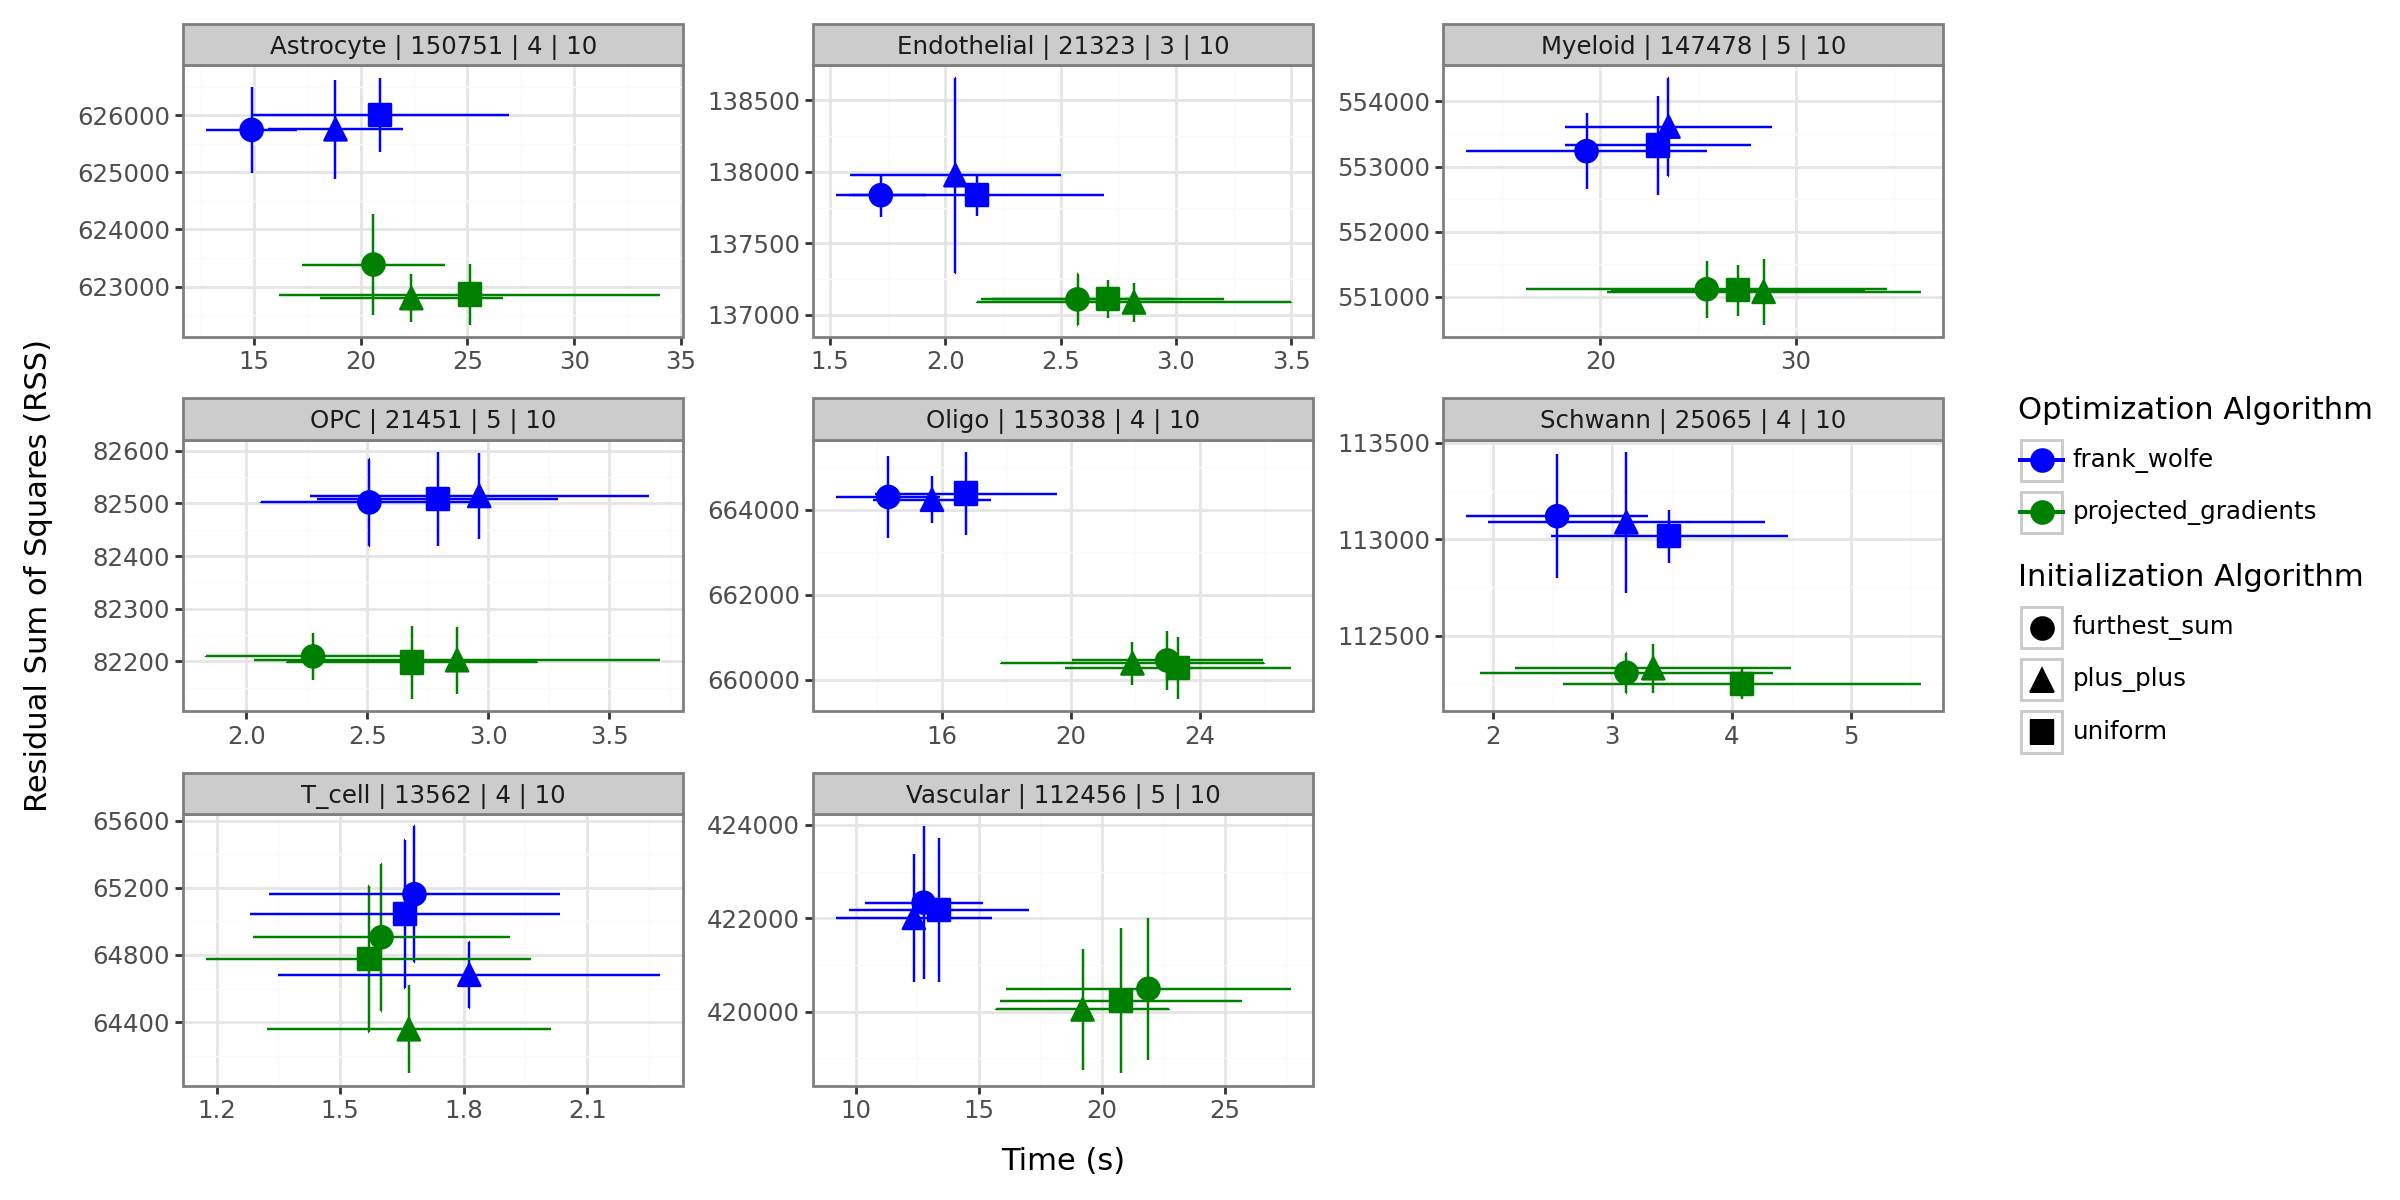

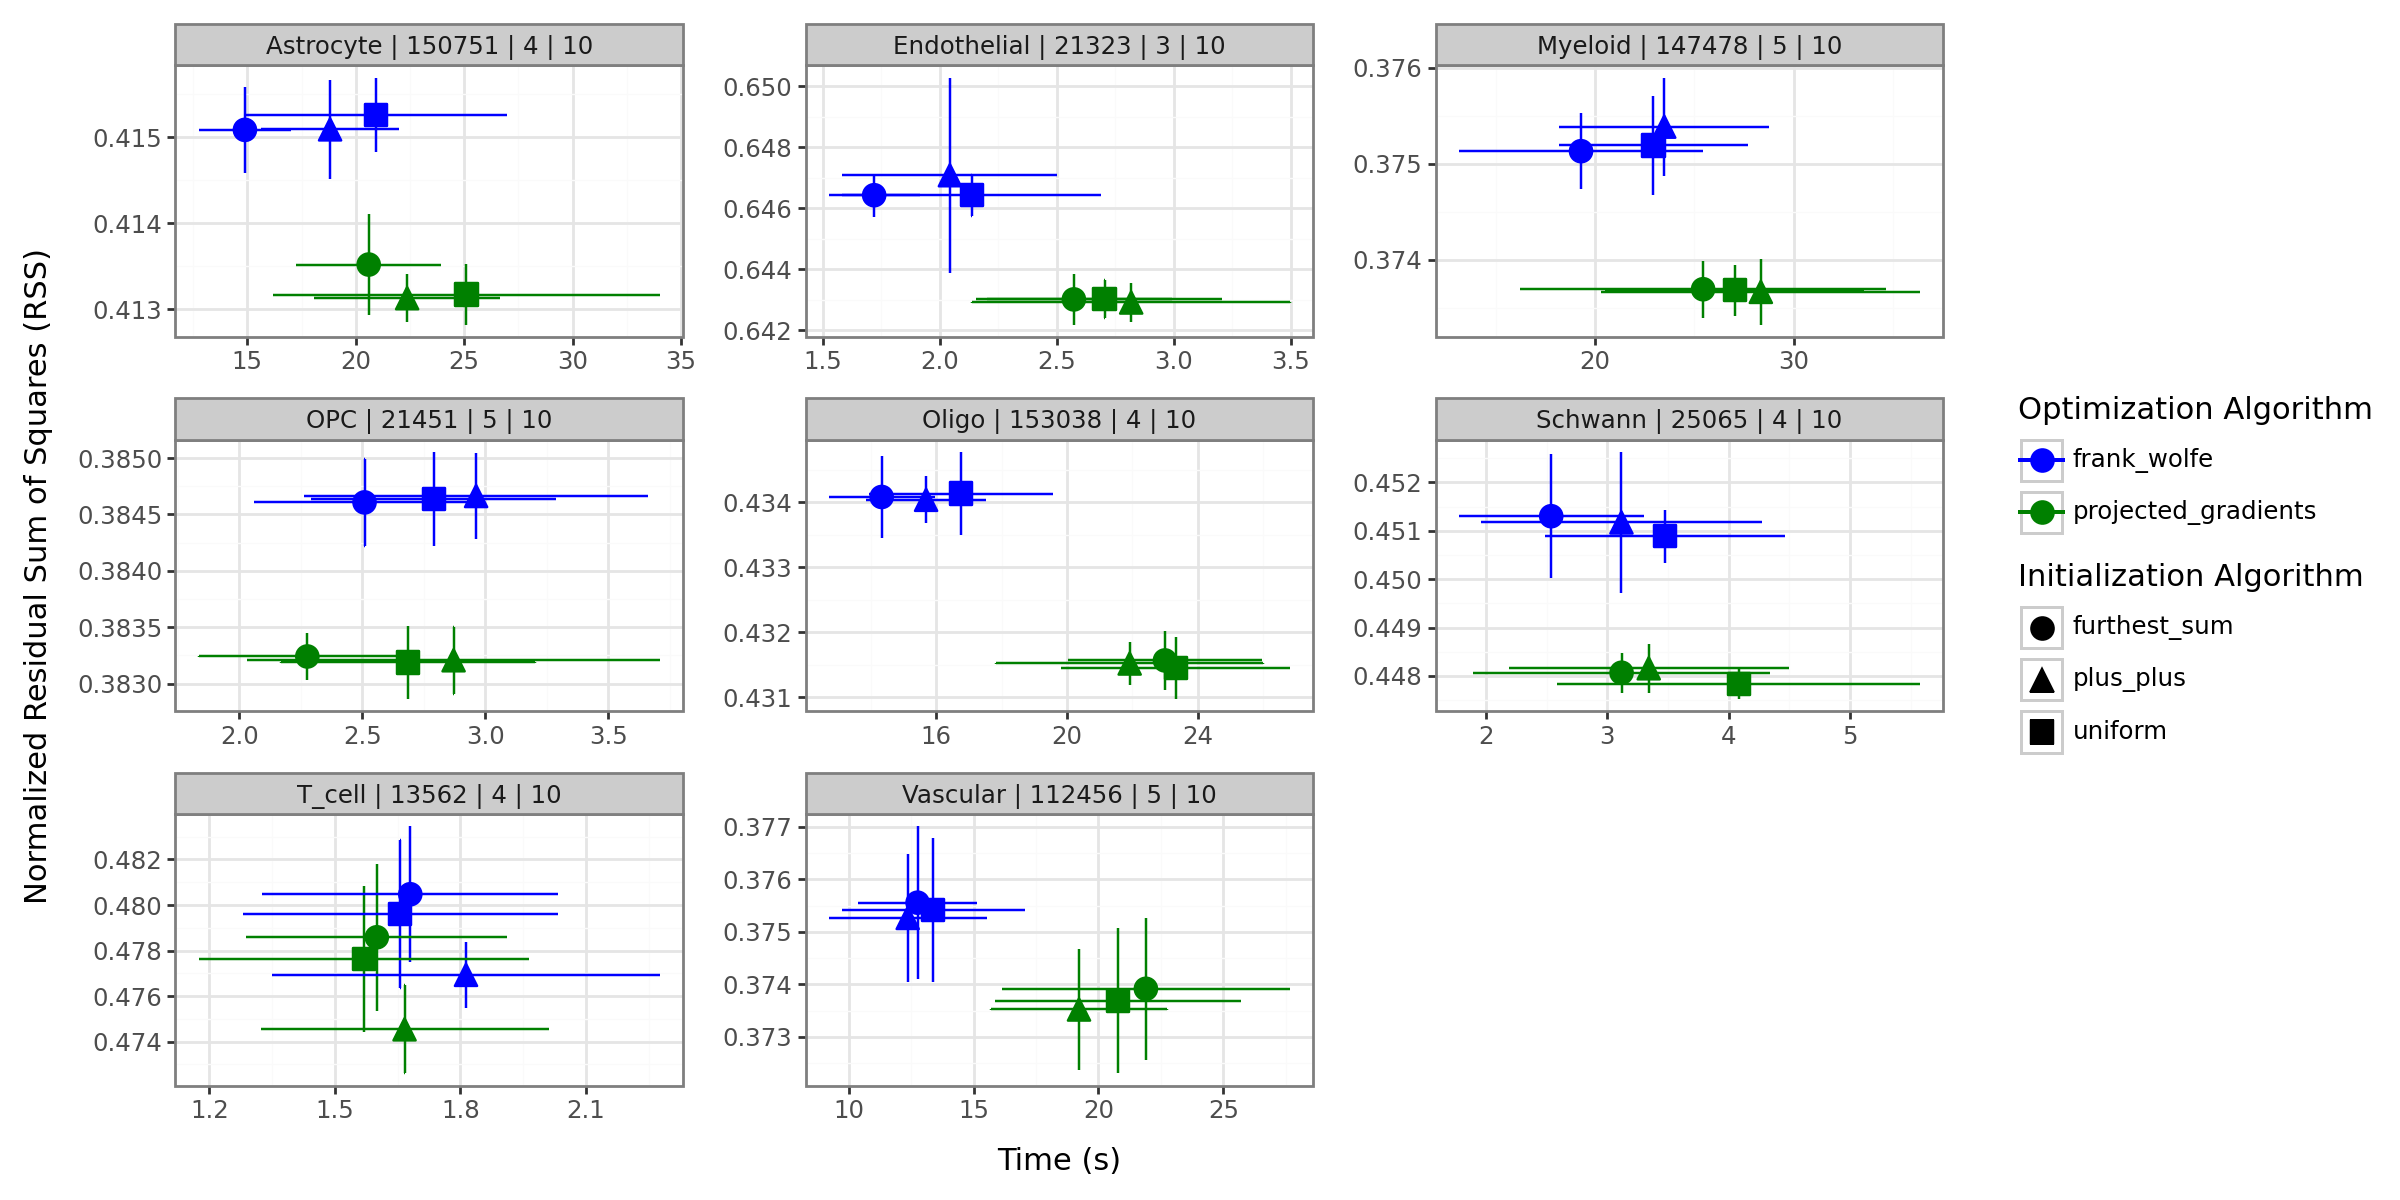

In [48]:
from pathlib import Path
import time
import pickle

from tqdm import tqdm
import numpy as np
import pandas as pd
import scanpy as sc
import partipy as pt
import plotnine as pn
import matplotlib
import matplotlib.pyplot as plt

from data_utils import load_ms_xenium_data
from const import FIGURE_PATH, OUTPUT_PATH, SEED_DICT

# Load and preprocess results
result_df = pd.read_csv(Path(OUTPUT_PATH) / "ms_xenium_bench" / "results.csv")
result_df["description"] = [celltype + " | " + str(n_samples) + " | " + str(n_arch) + " | " + str(n_dim) for celltype, n_samples, n_arch, n_dim in 
                            zip(result_df["celltype"], result_df["n_samples"], result_df["n_archetypes"], result_df["n_dimensions"])]
result_df["rss_norm"] = result_df["rss"] / (result_df["n_samples"] * result_df["n_dimensions"])
result_df["key"] = [init + "__" + optim for init, optim in zip(result_df["init_alg"], result_df["optim_alg"])]

# Grouping and aggregation
settings = ["description", "init_alg", "optim_alg"]
features = ["time", "rss", "varexpl", "rss_norm"]
agg_df = result_df.groupby(settings).agg({f: ["mean", "std"] for f in features})
agg_df.columns = ['__'.join(col).strip() for col in agg_df.columns.values]
agg_df = agg_df.reset_index()

# Precompute error bar limits
agg_df["rss__ymin"] = agg_df["rss__mean"] - agg_df["rss__std"]
agg_df["rss__ymax"] = agg_df["rss__mean"] + agg_df["rss__std"]
agg_df["rss_norm__ymin"] = agg_df["rss_norm__mean"] - agg_df["rss_norm__std"]
agg_df["rss_norm__ymax"] = agg_df["rss_norm__mean"] + agg_df["rss_norm__std"]
agg_df["time__xmin"] = agg_df["time__mean"] - agg_df["time__std"]
agg_df["time__xmax"] = agg_df["time__mean"] + agg_df["time__std"]

# Plot: RSS
p = (
    pn.ggplot(agg_df)
    + pn.geom_point(pn.aes(x="time__mean", y="rss__mean", color="optim_alg", shape="init_alg"), size=4)
    + pn.geom_errorbar(
        pn.aes(x="time__mean", ymin="rss__ymin", ymax="rss__ymax", color="optim_alg"), width=0)
    + pn.geom_errorbarh(
        pn.aes(y="rss__mean", xmin="time__xmin", xmax="time__xmax", color="optim_alg"), height=0)
    + pn.facet_wrap(facets="description", ncol=3, scales="free")
    + pn.labs(x="Time (s)", y="Residual Sum of Squares (RSS)", 
              color="Optimization Algorithm", shape="Initialization Algorithm") 
    + pn.theme_bw() 
    + pn.theme(figure_size=(12, 6)) 
    + pn.scale_color_manual(values={"projected_gradients": "green", "frank_wolfe": "blue"})
)
p.show()

# Plot: Normalized RSS
p = (
    pn.ggplot(agg_df)
    + pn.geom_point(pn.aes(x="time__mean", y="rss_norm__mean", color="optim_alg", shape="init_alg"), size=4)
    + pn.geom_errorbar(
        pn.aes(x="time__mean", ymin="rss_norm__ymin", ymax="rss_norm__ymax", color="optim_alg"), width=0)
    + pn.geom_errorbarh(
        pn.aes(y="rss_norm__mean", xmin="time__xmin", xmax="time__xmax", color="optim_alg"), height=0)
    + pn.facet_wrap(facets="description", ncol=3, scales="free")
    + pn.labs(x="Time (s)", y="Normalized Residual Sum of Squares (RSS)", 
              color="Optimization Algorithm", shape="Initialization Algorithm") 
    + pn.theme_bw() 
    + pn.theme(figure_size=(12, 6)) 
    + pn.scale_color_manual(values={"projected_gradients": "green", "frank_wolfe": "blue"})
)
p.show()

In [41]:
result_df["celltype"]

0       Oligo
1       Oligo
2       Oligo
3       Oligo
4       Oligo
        ...  
955    T_cell
956    T_cell
957    T_cell
958    T_cell
959    T_cell
Name: celltype, Length: 960, dtype: object

In [ ]:
result_df["description"] = [celltype + " | " + n_samples + " | " + n_arch for celltype, n_samples, n_arch in zip(result_df["celltype"], result_df["n_samples"], result_df["n_archetypes"])]

,celltype,time,rss,varexpl,seed,n_samples,n_dimensions,n_archetypes,init_alg,optim_alg,rss_norm,key
0,Oligo,23.489684,660777.400,0.568229,383329927,153038,10,4,uniform,projected_gradients,0.431773,uniform__projected_gradients
1,Oligo,24.117721,659185.800,0.569269,3324115916,153038,10,4,uniform,projected_gradients,0.430733,uniform__projected_gradients
2,Oligo,19.596323,660063.000,0.568696,2811363264,153038,10,4,uniform,projected_gradients,0.431307,uniform__projected_gradients
3,Oligo,16.751760,661134.940,0.567995,1884968544,153038,10,4,uniform,projected_gradients,0.432007,uniform__projected_gradients
4,Oligo,29.197500,660296.900,0.568543,1859786275,153038,10,4,uniform,projected_gradients,0.431459,uniform__projected_gradients
...,...,...,...,...,...,...,...,...,...,...,...,...
955,T_cell,2.576269,64591.824,0.523729,3376120482,13562,10,4,plus_plus,frank_wolfe,0.476271,plus_plus__frank_wolfe
956,T_cell,2.223020,64550.516,0.524034,2204291346,13562,10,4,plus_plus,frank_wolfe,0.475966,plus_plus__frank_wolfe
957,T_cell,1.535925,64616.520,0.523548,550243861,13562,10,4,plus_plus,frank_wolfe,0.476453,plus_plus__frank_wolfe
958,T_cell,1.855642,64629.996,0.523448,3606691181,13562,10,4,plus_plus,frank_wolfe,0.476552,plus_plus__frank_wolfe


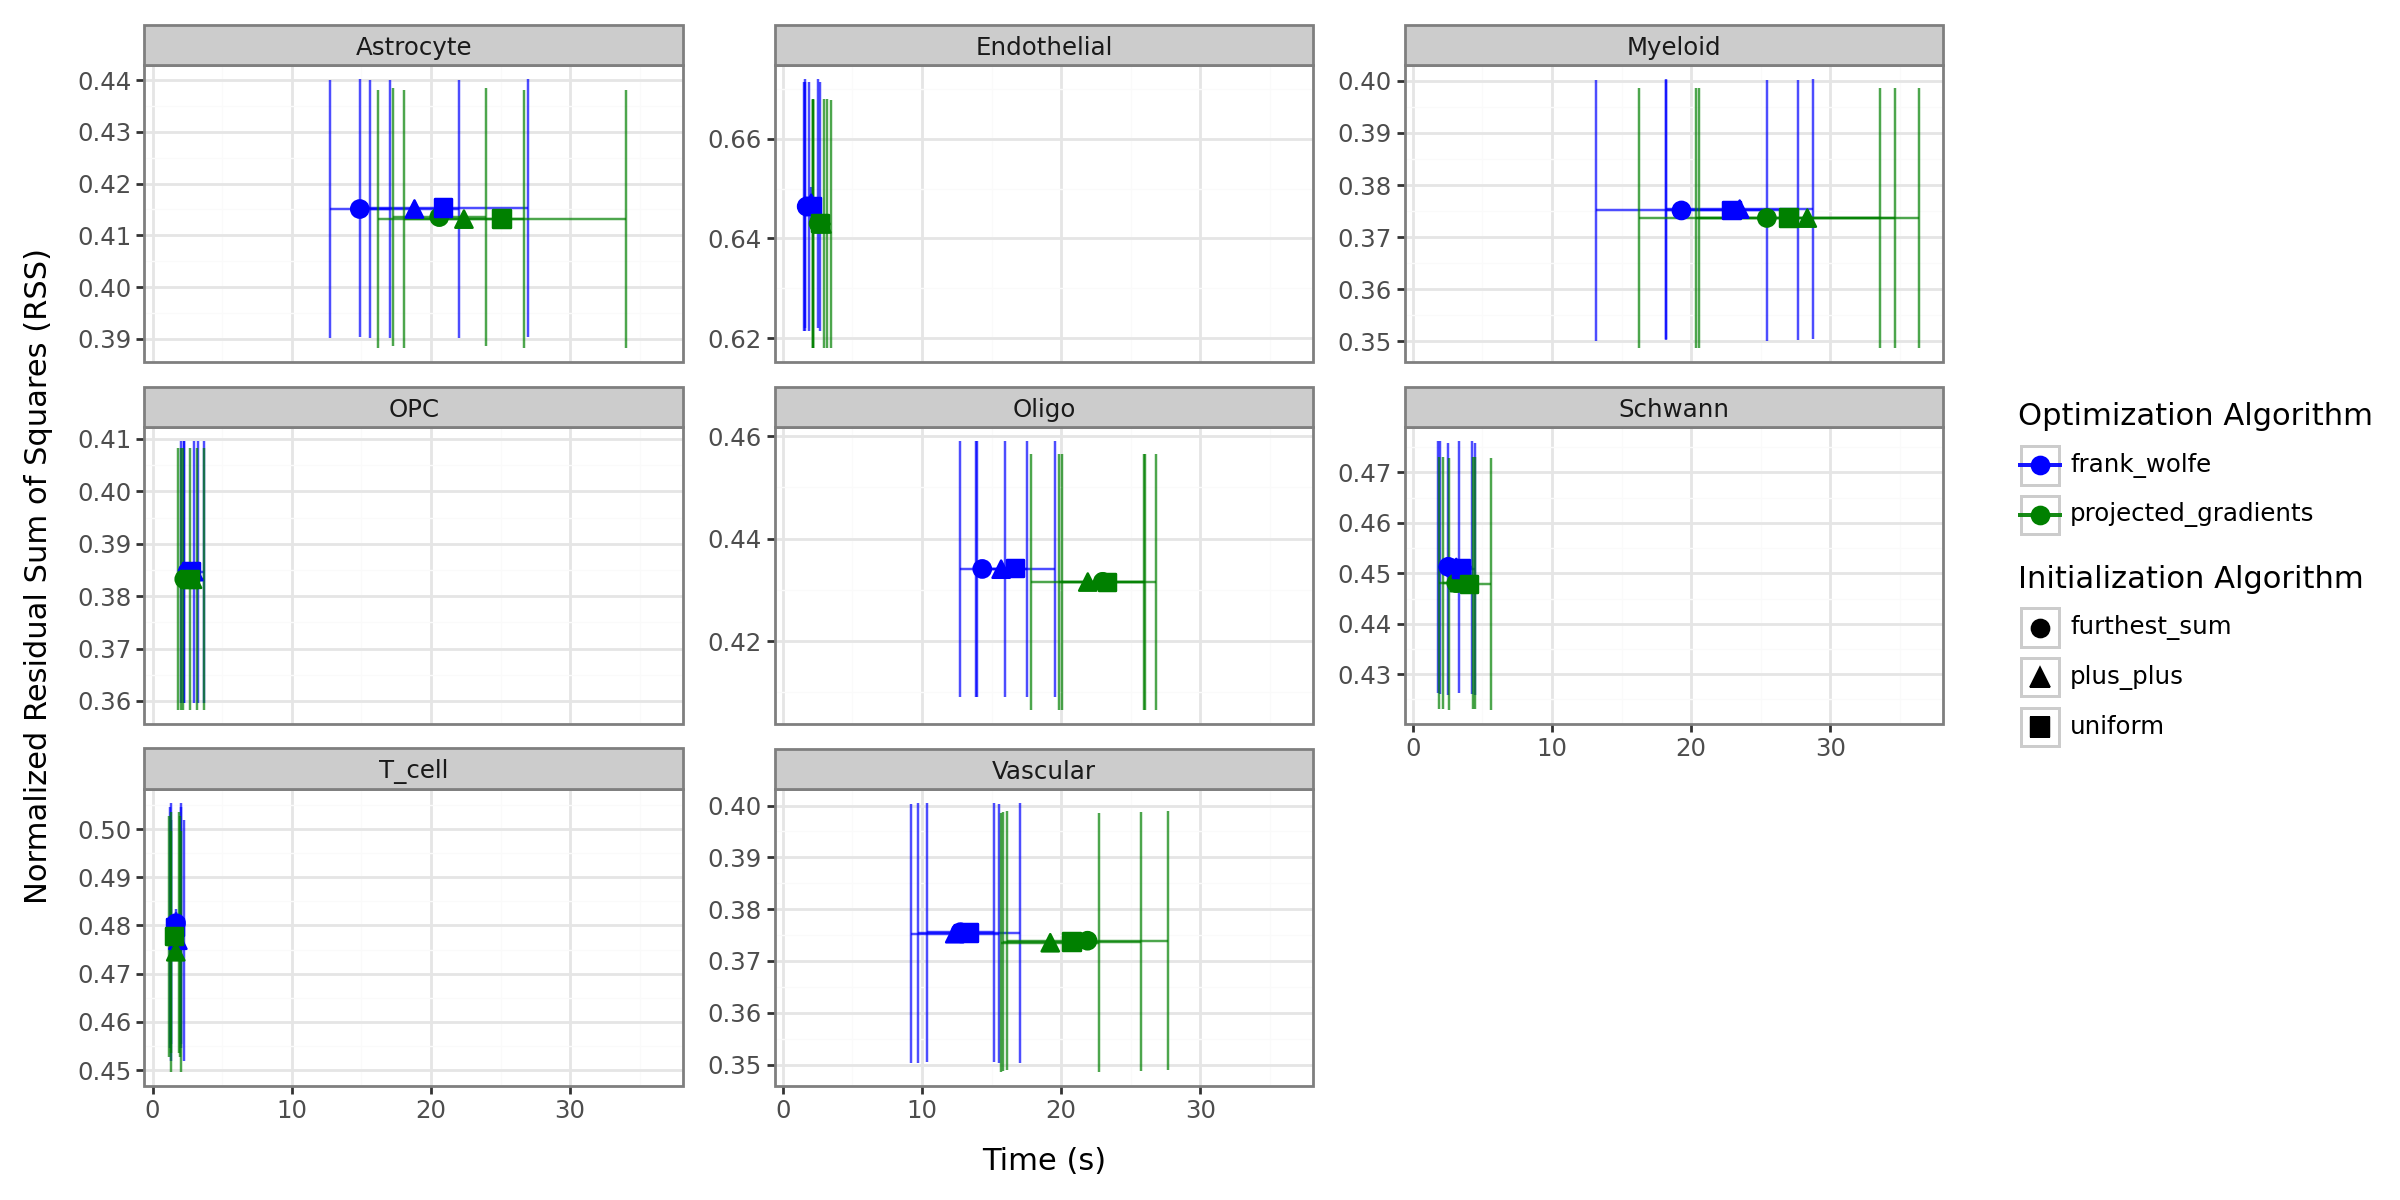

In [29]:
p = (
    pn.ggplot(agg_df)
    + pn.geom_linerange(
        pn.aes(x="time__mean", ymin="rss_norm__ymin", ymax="rss_norm__ymax", color="optim_alg"), alpha=0.7
    )
    + pn.geom_errorbarh(
        pn.aes(y="rss_norm__mean", xmin="time__xmin", xmax="time__xmax", color="optim_alg"), height=0.05, alpha=0.7
    )
    + pn.geom_point(pn.aes(x="time__mean", y="rss_norm__mean", color="optim_alg", shape="init_alg"), size=3)
    + pn.facet_wrap("celltype", ncol=3, scales="free_y")  # can switch to 'fixed' if preferred
    + pn.labs(
        x="Time (s)", y="Normalized Residual Sum of Squares (RSS)", 
        color="Optimization Algorithm", shape="Initialization Algorithm"
    )
    + pn.theme_bw()
    + pn.theme(figure_size=(12, 6))
    + pn.scale_color_manual(values={"projected_gradients": "green", "frank_wolfe": "blue"})
)
p.show()

In [28]:
print(agg_df[["rss_norm__mean", "rss_norm__std", "rss_norm__ymin", "rss_norm__ymax"]].describe())

       rss_norm__mean  rss_norm__std  rss_norm__ymin  rss_norm__ymax
count       48.000000      48.000000       48.000000       48.000000
mean         0.444035       0.000940        0.443096        0.444975
std          0.084403       0.000873        0.084161        0.084654
min          0.373519       0.000208        0.372301        0.373946
25%          0.381279       0.000387        0.380866        0.381839
50%          0.423352       0.000558        0.422897        0.423765
75%          0.457111       0.001300        0.455908        0.458591
max          0.647080       0.003253        0.645757        0.650281


In [27]:
agg_df

,celltype,init_alg,optim_alg,time__mean,time__std,rss__mean,rss__std,varexpl__mean,varexpl__std,rss_norm__mean,rss_norm__std,rss__ymin,rss__ymax,rss_norm__ymin,rss_norm__ymax,time__xmin,time__xmax
0,Astrocyte,furthest_sum,frank_wolfe,14.888663,2.140394,625741.20800,751.377695,0.584920,0.000498,0.415083,0.000498,624989.830305,626492.585695,0.414584,0.415581,12.748269,17.029057
1,Astrocyte,furthest_sum,projected_gradients,20.597113,3.353849,623385.75500,880.703050,0.586482,0.000584,0.413520,0.000584,622505.051950,624266.458050,0.412936,0.414104,17.243264,23.950962
2,Astrocyte,plus_plus,frank_wolfe,18.816534,3.164250,625750.65400,863.410892,0.584914,0.000573,0.415089,0.000573,624887.243108,626614.064892,0.414516,0.415662,15.652284,21.980784
3,Astrocyte,plus_plus,projected_gradients,22.370211,4.280652,622797.36800,423.152834,0.586873,0.000281,0.413130,0.000281,622374.215166,623220.520834,0.412849,0.413411,18.089560,26.650863
4,Astrocyte,uniform,frank_wolfe,20.920333,6.042253,626005.46500,649.351364,0.584744,0.000431,0.415258,0.000431,625356.113636,626654.816364,0.414827,0.415689,14.878080,26.962587
5,Astrocyte,uniform,projected_gradients,25.107866,8.929240,622860.81700,528.606211,0.586830,0.000351,0.413172,0.000351,622332.210789,623389.423211,0.412821,0.413523,16.178625,34.037106
6,Endothelial,furthest_sum,frank_wolfe,1.720199,0.194221,137837.02400,151.501670,0.353576,0.000711,0.646424,0.000711,137685.522330,137988.525670,0.645714,0.647135,1.525978,1.914419
7,Endothelial,furthest_sum,projected_gradients,2.572994,0.418271,137108.22950,177.521642,0.356994,0.000833,0.643006,0.000833,136930.707858,137285.751142,0.642174,0.643839,2.154723,2.991265
8,Endothelial,plus_plus,frank_wolfe,2.043600,0.459072,137976.96700,682.349160,0.352920,0.003200,0.647080,0.003200,137294.617840,138659.316160,0.643880,0.650281,1.584528,2.502672
9,Endothelial,plus_plus,projected_gradients,2.817748,0.679069,137086.62600,139.474967,0.357095,0.000654,0.642905,0.000654,136947.151033,137226.100967,0.642251,0.643559,2.138679,3.496816


In [ ]:
result_df = pd.read_csv(Path(OUTPUT_PATH) / "ms_xenium_bench" / "results.csv")
result_df["rss_norm"] = result_df["rss"] / (result_df["n_samples"] * result_df["n_dimensions"])
result_df["key"] = [init + "__" + optim for init, optim in zip(result_df["init_alg"], result_df["optim_alg"])]
settings = ["celltype", "init_alg", "optim_alg"]
features = ["time", "rss", "varexpl", "rss_norm"]
agg_df = result_df.groupby(settings).agg({f: ["mean", "std"] for f in features})
agg_df.columns = ['__'.join(col).strip() for col in agg_df.columns.values]
agg_df = agg_df.reset_index()




In [21]:
g = result_df.groupby(settings)
print(g.get_group(("Oligo", "plus_plus", "projected_gradients"))["rss_norm"].std())

0.00032605083589198344


In [24]:
agg_df

,celltype,init_alg,optim_alg,time__mean,time__std,rss__mean,rss__std,varexpl__mean,varexpl__std,rss_norm__mean,rss_norm__std,rss__ymin,rss__ymax,rss_norm__ymin,rss_norm__ymax,time__xmin,time__xmax
0,Astrocyte,furthest_sum,frank_wolfe,14.888663,2.140394,625741.20800,751.377695,0.584920,0.000498,0.415083,0.000498,624989.830305,626492.585695,0.414584,0.415581,12.748269,17.029057
1,Astrocyte,furthest_sum,projected_gradients,20.597113,3.353849,623385.75500,880.703050,0.586482,0.000584,0.413520,0.000584,622505.051950,624266.458050,0.412936,0.414104,17.243264,23.950962
2,Astrocyte,plus_plus,frank_wolfe,18.816534,3.164250,625750.65400,863.410892,0.584914,0.000573,0.415089,0.000573,624887.243108,626614.064892,0.414516,0.415662,15.652284,21.980784
3,Astrocyte,plus_plus,projected_gradients,22.370211,4.280652,622797.36800,423.152834,0.586873,0.000281,0.413130,0.000281,622374.215166,623220.520834,0.412849,0.413411,18.089560,26.650863
4,Astrocyte,uniform,frank_wolfe,20.920333,6.042253,626005.46500,649.351364,0.584744,0.000431,0.415258,0.000431,625356.113636,626654.816364,0.414827,0.415689,14.878080,26.962587
5,Astrocyte,uniform,projected_gradients,25.107866,8.929240,622860.81700,528.606211,0.586830,0.000351,0.413172,0.000351,622332.210789,623389.423211,0.412821,0.413523,16.178625,34.037106
6,Endothelial,furthest_sum,frank_wolfe,1.720199,0.194221,137837.02400,151.501670,0.353576,0.000711,0.646424,0.000711,137685.522330,137988.525670,0.645714,0.647135,1.525978,1.914419
7,Endothelial,furthest_sum,projected_gradients,2.572994,0.418271,137108.22950,177.521642,0.356994,0.000833,0.643006,0.000833,136930.707858,137285.751142,0.642174,0.643839,2.154723,2.991265
8,Endothelial,plus_plus,frank_wolfe,2.043600,0.459072,137976.96700,682.349160,0.352920,0.003200,0.647080,0.003200,137294.617840,138659.316160,0.643880,0.650281,1.584528,2.502672
9,Endothelial,plus_plus,projected_gradients,2.817748,0.679069,137086.62600,139.474967,0.357095,0.000654,0.642905,0.000654,136947.151033,137226.100967,0.642251,0.643559,2.138679,3.496816


In [22]:
agg_df

,celltype,init_alg,optim_alg,time__mean,time__std,rss__mean,rss__std,varexpl__mean,varexpl__std,rss_norm__mean,rss_norm__std
0,Astrocyte,furthest_sum,frank_wolfe,14.888663,2.140394,625741.20800,751.377695,0.584920,0.000498,0.415083,0.000498
1,Astrocyte,furthest_sum,projected_gradients,20.597113,3.353849,623385.75500,880.703050,0.586482,0.000584,0.413520,0.000584
2,Astrocyte,plus_plus,frank_wolfe,18.816534,3.164250,625750.65400,863.410892,0.584914,0.000573,0.415089,0.000573
3,Astrocyte,plus_plus,projected_gradients,22.370211,4.280652,622797.36800,423.152834,0.586873,0.000281,0.413130,0.000281
4,Astrocyte,uniform,frank_wolfe,20.920333,6.042253,626005.46500,649.351364,0.584744,0.000431,0.415258,0.000431
5,Astrocyte,uniform,projected_gradients,25.107866,8.929240,622860.81700,528.606211,0.586830,0.000351,0.413172,0.000351
6,Endothelial,furthest_sum,frank_wolfe,1.720199,0.194221,137837.02400,151.501670,0.353576,0.000711,0.646424,0.000711
7,Endothelial,furthest_sum,projected_gradients,2.572994,0.418271,137108.22950,177.521642,0.356994,0.000833,0.643006,0.000833
8,Endothelial,plus_plus,frank_wolfe,2.043600,0.459072,137976.96700,682.349160,0.352920,0.003200,0.647080,0.003200
9,Endothelial,plus_plus,projected_gradients,2.817748,0.679069,137086.62600,139.474967,0.357095,0.000654,0.642905,0.000654


In [3]:
result_df["rss"] / (result_df["n_samples"] * result_df["n_dimensions"])

0      0.431773
1      0.430733
2      0.431307
3      0.432007
4      0.431459
         ...   
955    0.476271
956    0.475966
957    0.476453
958    0.476552
959    0.476064
Length: 960, dtype: float64

In [17]:
#df = result_df.loc[(result_df["celltype"]=="Oligo") & (result_df["init_alg"]=="plus_plus") & (result_df["optim_alg"]=="projected_gradients"), :].copy()
df = result_df.loc[(result_df["celltype"]=="Oligo") & (result_df["init_alg"]=="plus_plus") & (result_df["optim_alg"]=="frank_wolfe"), :].copy()
df

,celltype,time,rss,varexpl,seed,n_samples,n_dimensions,n_archetypes,init_alg,optim_alg,rss_norm,key
100,Oligo,15.051230,664213.40,0.565984,383329927,153038,10,4,plus_plus,frank_wolfe,0.434019,plus_plus__frank_wolfe
101,Oligo,13.666242,663684.30,0.566330,3324115916,153038,10,4,plus_plus,frank_wolfe,0.433673,plus_plus__frank_wolfe
102,Oligo,15.047018,664552.44,0.565762,2811363264,153038,10,4,plus_plus,frank_wolfe,0.434240,plus_plus__frank_wolfe
103,Oligo,13.569071,663604.10,0.566382,1884968544,153038,10,4,plus_plus,frank_wolfe,0.433620,plus_plus__frank_wolfe
104,Oligo,17.399856,663826.20,0.566237,1859786275,153038,10,4,plus_plus,frank_wolfe,0.433766,plus_plus__frank_wolfe
105,Oligo,15.818825,664846.40,0.565570,3687649985,153038,10,4,plus_plus,frank_wolfe,0.434432,plus_plus__frank_wolfe
106,Oligo,15.572694,664458.30,0.565824,369133708,153038,10,4,plus_plus,frank_wolfe,0.434179,plus_plus__frank_wolfe
107,Oligo,18.317338,664307.25,0.565922,2995172877,153038,10,4,plus_plus,frank_wolfe,0.434080,plus_plus__frank_wolfe
108,Oligo,16.179093,665093.94,0.565408,865305066,153038,10,4,plus_plus,frank_wolfe,0.434594,plus_plus__frank_wolfe
109,Oligo,16.217129,664502.90,0.565795,404488628,153038,10,4,plus_plus,frank_wolfe,0.434208,plus_plus__frank_wolfe


In [19]:
df["rss"].std()

np.float64(556.3888681290244)